In [26]:
import jax
import jax.numpy as jnp
import numpy as np
import flashbax as fbx
from flashbax.vault import Vault
from scipy.stats import norm
import matplotlib.pyplot as plt
import copy
import flashbax
from flashbax.buffers.trajectory_buffer import TrajectoryBufferState
import pickle
import seaborn as sns
from produce_count_info import create_count_information
from subsample_vault import subsample_smaller_vault

# Processing coverage information for a multi-agent dataset
We start with:
- values, reverse indexes (for rebuilding/reference back to original vault), counts

We want the following:
- a measure of diversity of actions per state
- a measure of diversity of observed rewards per state-action pair
- a measure of how much of the data is unique
- a measure of skewness - maybe an exponential like we see with that one law

Further, we want: 
- for each task, 
- - for each dataset - random, other
- - - SACo
- - - joint OACo
- - - per-agent OACo
- - Then, for each dataset notequalto random
- - - relative SACo
- - - relative OACo
- - - relative per-agent OACo

In [27]:
# set to False to reduce storage requirements
need_to_reconstruct=False
random_dataset_uid_pos = -2

In [28]:
rel_dir = "vaults/smac_v1"
vault_name = "5m_vs_6m"
vault_uids=["Good","Medium","Poor"]

for vault_uid in vault_uids:

    # make a smaller vault - it is easier for memory to handle
    new_vault_name = subsample_smaller_vault(rel_dir,vault_name,vault_uid,10000)

    # for each new vault, store count information at the new vault location
    # the need to reconstruct option allows us to store more or less information
    keys = create_count_information(rel_dir, new_vault_name, vault_uid, need_to_reconstruct)

Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/smac_v1/5m_vs_6m.vlt/Good
New vault created at /home/louise/workspace/og-marl/development/clean_utils/vaults/smac_v1/5m_vs_6m_10000.vlt/Good
Since the provided buffer state has a temporal dimension of 500000, you must write to the vault at least every 499999 timesteps to avoid data loss.
9993
Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/smac_v1/5m_vs_6m_10000.vlt/Good
agent_0
Number of unique: 7235
Most repeated pair's count: 1464
agent_1
Number of unique: 7374
Most repeated pair's count: 1345
agent_2
Number of unique: 7355
Most repeated pair's count: 1377
agent_3
Number of unique: 6933
Most repeated pair's count: 1768
agent_4
Number of unique: 7097
Most repeated pair's count: 1655
joint
Number of unique: 8723
Most repeated pair's count: 341
state
Number of unique: 8877
Most repeated pair's count: 23
Loading vault found at /home/louise/workspace/og-marl/developme

In [30]:
counts_over_datasets = {}

for uid in vault_uids:
    with open(rel_dir+"/"+new_vault_name+"/"+uid+"/count_info.pickle","rb") as f:
        counts_over_datasets[uid] = pickle.load(f)


In [31]:
all_ratios = []

for key in keys:
    num_unique = []
    # for the joint
    for i,uid in enumerate(vault_uids):
        if ~need_to_reconstruct:
            (counts, rewards) = counts_over_datasets[uid]
            num_unique.append(counts[key].shape[0])

    num_unique = np.array(num_unique)
    if random_dataset_uid_pos!=-2:
        num_unique = num_unique/num_unique[random_dataset_uid_pos]

    all_ratios.append(num_unique)


In [32]:
print("\t\t"+str(vault_uids))
for row, key in zip(all_ratios,keys):
    print(key+":   \t"+str(row))

		['Good', 'Medium', 'Poor']
agent_0:   	[7235 7121 7126]
agent_1:   	[7374 7131 5912]
agent_2:   	[7355 7379 6587]
agent_3:   	[6933 7070 6200]
agent_4:   	[7097 7425 6547]
joint:   	[8723 9007 8772]
state:   	[8877 9259 9228]


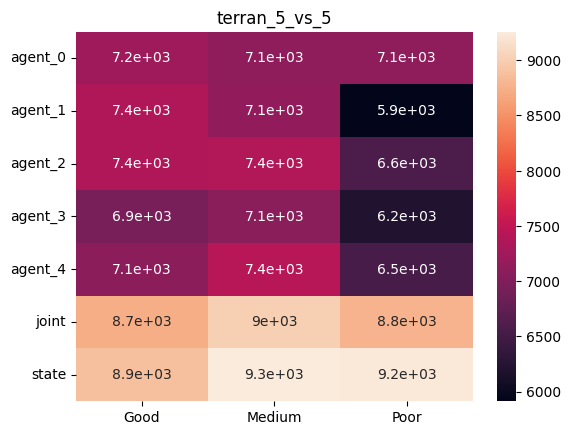

In [53]:
sns.heatmap(np.array(all_ratios),xticklabels=vault_uids,yticklabels=keys,annot=True)
plt.title("terran_5_vs_5")
plt.savefig(rel_dir+"/"+new_vault_name+"/"+"OACo_heatmap.png")

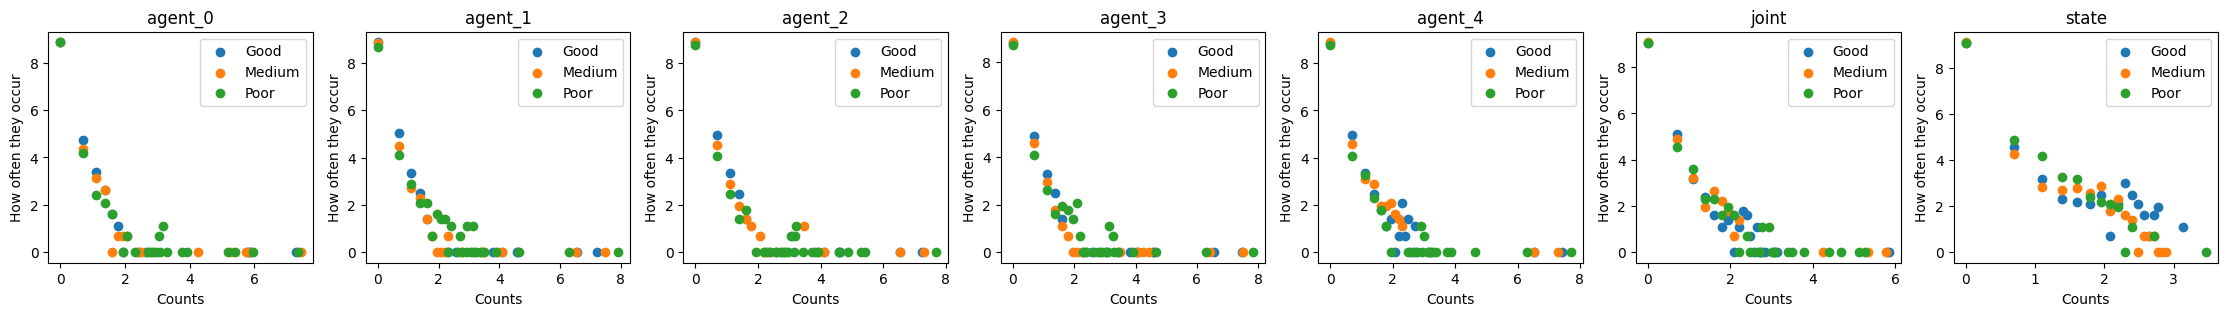

In [52]:
fig, ax = plt.subplots(1,len(keys),figsize=(4*len(keys),3))

for j, key in enumerate(keys):
    for i,uid in enumerate(vault_uids):
        (counts, rewards) = counts_over_datasets[uid]
        vals2, counts2 = np.unique(counts[key],return_counts=True)

        ax[j].scatter(np.log(vals2),np.log(counts2),label=uid)
        ax[j].set_xlabel("Counts")
        ax[j].set_ylabel("How often they occur")
        ax[j].set_title(key)
        ax[j].legend()

plt.savefig(rel_dir+"/"+new_vault_name+"/"+"per_agent_loglog.png",bbox_inches="tight")
plt.show()

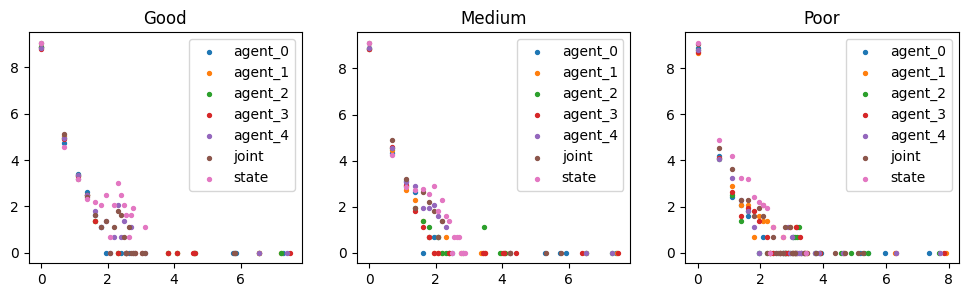

In [51]:

fig, ax = plt.subplots(1,len(vault_uids), figsize=(4*len(vault_uids),3))

for key in keys:

    for i,uid in enumerate(vault_uids):
        (counts, rewards) = counts_over_datasets[uid]
        vals2, counts2 = np.unique(counts[key],return_counts=True)

        ax[i].scatter(np.log(vals2),np.log(counts2),label=key,s=8)
        ax[i].legend()
        ax[i].set_title(uid)

plt.savefig(rel_dir+"/"+new_vault_name+"/"+"per_dataset_loglog.png",bbox_inches='tight')
plt.show()